Basic setup

In [346]:
import pandas as pd
import yfinance as yf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt

Import Apple dataset and look at them.

In [347]:
appl = yf.Ticker('AAPL')
appl.info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

In [348]:
hist = appl.history(period='1y')

appl.history_metadata

{'currency': 'USD',
 'symbol': 'AAPL',
 'exchangeName': 'NMS',
 'fullExchangeName': 'NasdaqGS',
 'instrumentType': 'EQUITY',
 'firstTradeDate': 345479400,
 'regularMarketTime': 1717010378,
 'hasPrePostMarketData': True,
 'gmtoffset': -14400,
 'timezone': 'EDT',
 'exchangeTimezoneName': 'America/New_York',
 'regularMarketPrice': 190.92,
 'fiftyTwoWeekHigh': 192.247,
 'fiftyTwoWeekLow': 189.51,
 'regularMarketDayHigh': 192.247,
 'regularMarketDayLow': 189.51,
 'regularMarketVolume': 35813383,
 'chartPreviousClose': 175.43,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'EDT',
   'start': 1716969600,
   'end': 1716989400,
   'gmtoffset': -14400},
  'regular': {'timezone': 'EDT',
   'start': 1716989400,
   'end': 1717012800,
   'gmtoffset': -14400},
  'post': {'timezone': 'EDT',
   'start': 1717012800,
   'end': 1717027200,
   'gmtoffset': -14400}},
 'dataGranularity': '1d',
 'range': '1y',
 'validRanges': ['1d',
  '5d',
  '1mo',
  '3mo',
  '6mo',
  '1y',
  '2y',
  '5y',
  

In [349]:
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=1)

apple_data = appl.history(start = start_date, end = end_date)

apple_data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-05-30 00:00:00-04:00,176.025173,178.044447,175.637233,176.363373,55964400,0.0,0.0
2023-05-31 00:00:00-04:00,176.393208,178.402541,175.826212,176.313629,99625300,0.0,0.0
2023-06-01 00:00:00-04:00,176.761252,179.168466,175.995316,179.138626,68901800,0.0,0.0
2023-06-02 00:00:00-04:00,180.073674,180.819712,178.313020,179.994095,61945900,0.0,0.0
2023-06-05 00:00:00-04:00,181.665223,183.972959,177.099459,178.631332,121946500,0.0,0.0


In [350]:
apple_data.reset_index(inplace=True)
apple_data['Date'] = pd.to_datetime(apple_data['Date'])

apple_data['Day_of_Week'] = apple_data['Date'].dt.dayofweek
apple_data['Day_of_Month'] = apple_data['Date'].dt.day
apple_data['Month'] = apple_data['Date'].dt.month
apple_data['Day_of_Year'] = apple_data['Date'].dt.dayofyear

for lag in range(1,6):
    apple_data[f'Close_lag_{lag}'] = apple_data['Close'].shift(lag)

apple_data.sample(5)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Day_of_Week,Day_of_Month,Month,Day_of_Year,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
106,2023-10-30 00:00:00-04:00,168.354140,170.495663,168.204721,169.619125,51131000,0.0,0.0,0,30,10,303,167.557312,166.232559,170.425980,172.756744,172.318481
75,2023-09-15 00:00:00-04:00,175.784752,175.804677,173.135242,174.320541,109205100,0.0,0.0,4,15,9,258,175.047684,173.523712,175.605484,178.653412,177.478058
240,2024-05-13 00:00:00-04:00,185.440002,187.100006,184.619995,186.279999,72044800,0.0,0.0,0,13,5,134,183.050003,184.320007,182.492477,182.152924,181.463882
4,2023-06-05 00:00:00-04:00,181.665223,183.972959,177.099459,178.631332,121946500,0.0,0.0,0,5,6,156,179.994095,179.138626,176.313629,176.363373,NaN
93,2023-10-11 00:00:00-04:00,177.497972,179.141481,176.900345,179.091675,47551100,0.0,0.0,2,11,10,284,177.687241,178.284882,176.790802,174.220963,172.975891


We have got the data set of Apple in the past year. Now we want to generate a dataset of missing values in 5 days.

In [351]:
random_state = 27
np.random.seed(random_state)


missing_dates = np.random.choice(apple_data.index, size=5, replace=False)
apple_missing = apple_data.copy()
apple_missing.loc[missing_dates, 'Close'] = np.nan

Let us look at this new dataset. 

In [352]:
apple_missing.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Day_of_Week,Day_of_Month,Month,Day_of_Year,Close_lag_1,Close_lag_2,Close_lag_3,Close_lag_4,Close_lag_5
0,2023-05-30 00:00:00-04:00,176.025173,178.044447,175.637233,176.363373,55964400,0.0,0.0,1,30,5,150,NaN,NaN,NaN,NaN,NaN
1,2023-05-31 00:00:00-04:00,176.393208,178.402541,175.826212,176.313629,99625300,0.0,0.0,2,31,5,151,176.363373,NaN,NaN,NaN,NaN
2,2023-06-01 00:00:00-04:00,176.761252,179.168466,175.995316,179.138626,68901800,0.0,0.0,3,1,6,152,176.313629,176.363373,NaN,NaN,NaN
3,2023-06-02 00:00:00-04:00,180.073674,180.819712,178.313020,179.994095,61945900,0.0,0.0,4,2,6,153,179.138626,176.313629,176.363373,NaN,NaN
4,2023-06-05 00:00:00-04:00,181.665223,183.972959,177.099459,178.631332,121946500,0.0,0.0,0,5,6,156,179.994095,179.138626,176.313629,176.363373,NaN


In [353]:
len(apple_missing)

252

In [354]:
apple_missing.dtypes

Date            datetime64[ns, America/New_York]
Open                                     float64
High                                     float64
Low                                      float64
Close                                    float64
Volume                                     int64
Dividends                                float64
Stock Splits                             float64
Day_of_Week                                int32
Day_of_Month                               int32
Month                                      int32
Day_of_Year                                int32
Close_lag_1                              float64
Close_lag_2                              float64
Close_lag_3                              float64
Close_lag_4                              float64
Close_lag_5                              float64
dtype: object

In [355]:
missing_index = apple_missing[apple_missing['Close'].isna()].index
print(missing_index)


Index([10, 95, 149, 178, 205], dtype='int64')


In [356]:
data_non_missing = apple_missing.dropna(subset = ['Close'])
len(data_non_missing)

247

In [357]:
X = data_non_missing[['Open', 'Day_of_Week', 'Day_of_Month', 'Month', 'Day_of_Year']]
y = data_non_missing['Close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

data_missing = apple_missing[apple_missing['Close'].isnull()]
X_missing = data_missing[['Open', 'Day_of_Week', 'Day_of_Month', 'Month', 'Day_of_Year']]
X_missing_scaled = scaler.transform(X_missing)

close_missing = apple_data.loc[missing_dates, 'Close']

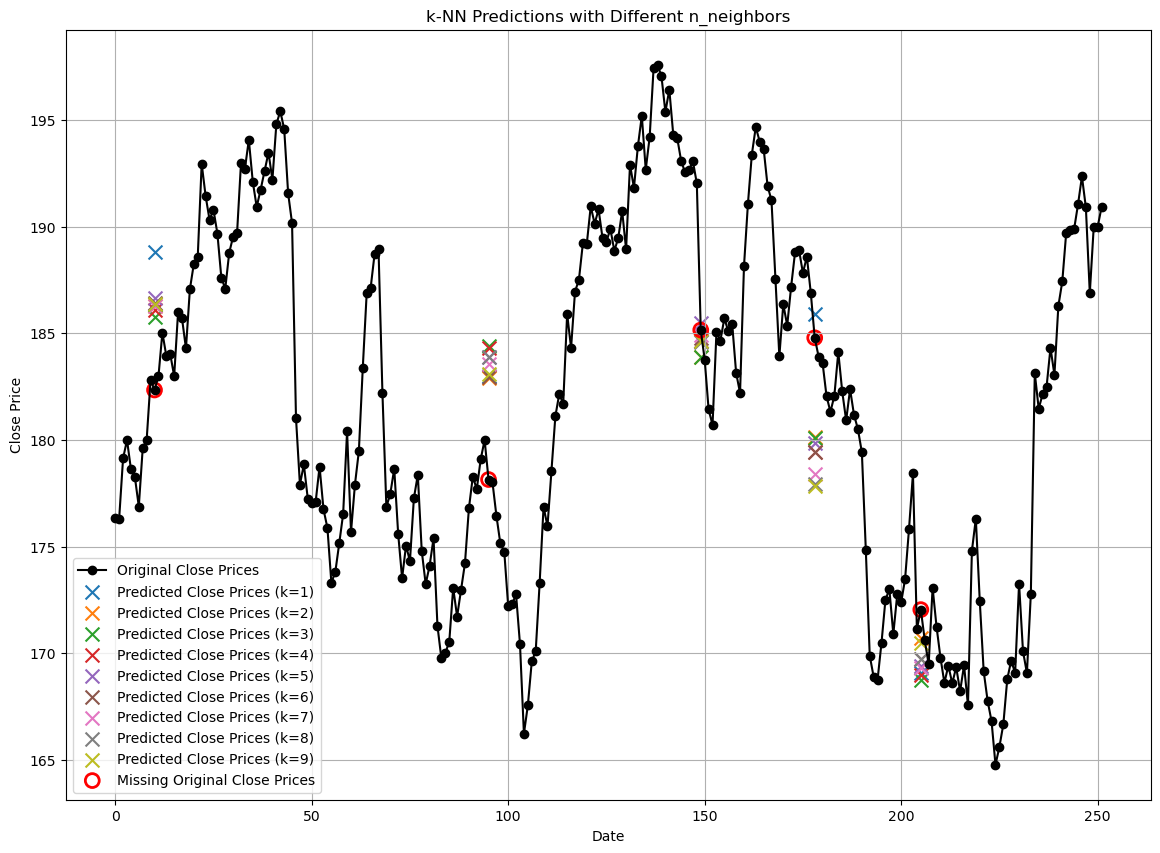

In [358]:
plt.figure(figsize=(14, 10))

plt.plot(apple_data.index, apple_data['Close'], label='Original Close Prices', linestyle='-', marker='o', color='black')
k_values = [i for i in range(1, 10)]
predictions = {}
mse_values = []
mae_values = []

for k in k_values:
    model = KNeighborsRegressor(n_neighbors= k)
    model.fit(X_scaled, y)
    predicted_close = model.predict(X_missing_scaled)
    predictions[k] = predicted_close

    mse = mean_squared_error(apple_data.loc[missing_dates, 'Close'], predicted_close[:len(missing_dates)])
    mse_values.append(mse)
    mae = mean_absolute_error(apple_data.loc[missing_dates, 'Close'], predicted_close[:len(missing_dates)])
    mae_values.append(mae)
    plt.scatter(missing_dates, predictions[k], label=f'Predicted Close Prices (k={k})', marker='x', s=100)

plt.scatter(missing_dates, apple_data.loc[missing_dates, 'Close'], label='Missing Original Close Prices', marker='o', s=100, edgecolor='red', facecolor='none', linewidths=2)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('k-NN Predictions with Different n_neighbors')
plt.legend()
plt.grid(True)
plt.show()

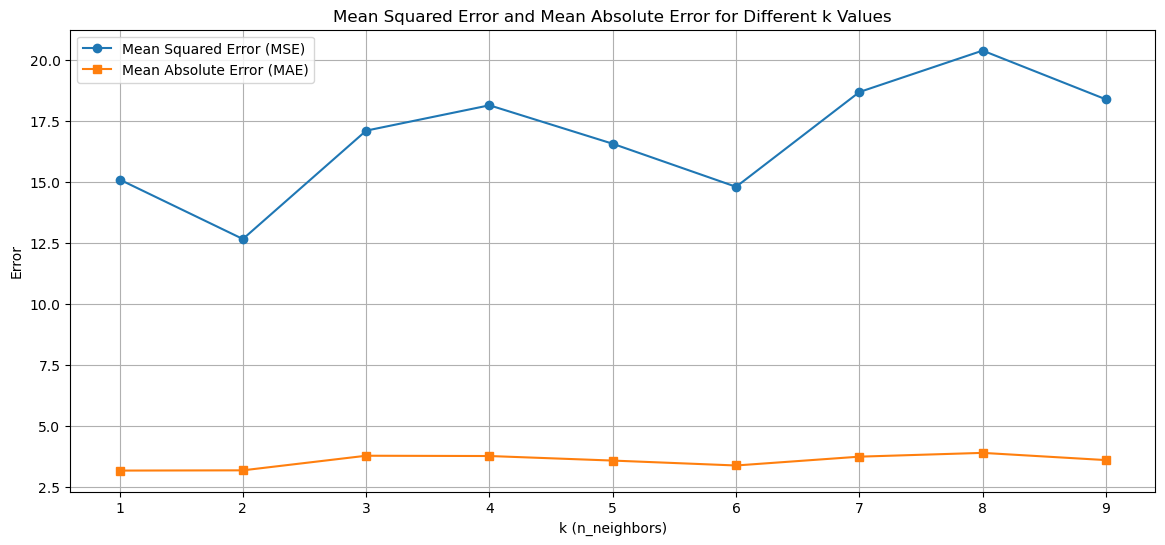

In [359]:
plt.figure(figsize=(14, 6))
plt.plot(k_values, mse_values, marker='o', label='Mean Squared Error (MSE)')
plt.plot(k_values, mae_values, marker='s', label='Mean Absolute Error (MAE)')
plt.xlabel('k (n_neighbors)')
plt.ylabel('Error')
plt.title('Mean Squared Error and Mean Absolute Error for Different k Values')
plt.legend()
plt.grid(True)
plt.show()